In [2]:
import pandas as pd
from idaes.core.solvers import get_solver
from pyomo.environ import ConcreteModel, RangeSet, Var, log10, minimize


In [3]:
df = pd.read_excel("data for parmest.xlsx", sheet_name = "Sheet1")
index = df.shape[0]
idx_list = RangeSet(0,index-1)
print(df)

      dosage        pH    logD Y   logD Ce   logD Nd   logD Sm   logD Gd  \
0   4.987853  0.241000 -1.640000 -1.920000 -1.810000 -1.670000 -1.850000   
1   4.978542  0.527000 -1.150000 -1.480000 -1.540000 -1.620000 -1.590000   
2   4.929476  0.796000 -0.460000 -1.510000 -1.460000 -1.550000 -1.420000   
3   4.813219  1.137000  0.350000 -1.340000 -1.440000 -1.550000 -1.160000   
4   4.751685  1.321000  0.870000 -1.300000 -1.320000 -1.110000 -0.800000   
5   4.723110  1.466000  1.200000 -1.170000 -1.190000 -0.850000 -0.520000   
6   4.709438  1.524000  1.350000 -1.020000 -1.000000 -0.720000 -0.340000   
7   1.991579  0.235616 -1.614155 -1.852616 -1.741725 -1.852616 -1.652822   
8   1.980691  0.528767 -1.170221 -1.458465 -1.514597 -1.578512 -1.578512   
9   1.933668  0.802740 -0.456245 -1.485682 -1.458465 -1.545445 -1.432752   
10  1.827041  1.167123  0.340148 -1.363124 -1.432752 -1.578512 -1.142054   
11  1.770545  1.416438  0.842269 -1.302435 -1.321819 -1.090050 -0.793946   
12  1.744097

In [4]:
Element_list = ['Y','Ce','Nd','Sm','Gd','Dy']

In [5]:
m = ConcreteModel()

m.pH = Var(idx_list)
m.dosage = Var(idx_list)
m.logD_exp = Var(idx_list, Element_list)
m.logD_model = Var(idx_list, Element_list)

for i in idx_list:
    m.pH[i].fix(df['pH'][i])
    m.dosage[i].fix(df['dosage'][i])
    for e in Element_list:
        m.logD_exp[i,e].fix(df[f'logD {e}'][i])

variable_list = [1,2]

# m.a = Var(variable_list, Element_list, initialize = 0.1)
# m.b = Var(variable_list, Element_list, initialize = 0.1)
m.a = Var(variable_list, Element_list, initialize=0.1, bounds=lambda m, i, e: (0, None) if i == 2 else (None, None))
m.b = Var(variable_list, Element_list, initialize=0.1, bounds=lambda m, i, e: (0, None) if i == 2 else (None, None))

# for e in Element_list:
#     m.b[2,e].set_lb(0)

@m.Constraint(idx_list, Element_list)
def logD_model_rule(m,i,e):
    return m.logD_model[i,e] == (m.a[1,e]+m.a[2,e]*m.dosage[i])*m.pH[i] + (m.b[1,e]+m.b[2,e]*log10(m.dosage[i]))

@m.Expression()
def SSE(m):
    return sum(((m.logD_exp[i,e] - m.logD_model[i,e])**2)*df[f'w_{e}'][i] for i in idx_list for e in Element_list)

@m.Objective(sense=minimize)
def objective_rule(m):
    return m.SSE

solver=get_solver('ipopt_v2')
solver.solve(m, tee=True)


Ipopt 3.13.2: linear_solver=ma57
max_iter=200
nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 

{'Problem': [{'Lower bound': None, 'Upper bound': 0.8465238733938472, 'Number of objectives': 1, 'Number of constraints': nan, 'Number of variables': nan, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.convergenceCriteriaSatisfied'}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [6]:
m.a.pprint()
m.b.pprint()

a : Size=12, Index={1, 2}*{Y, Ce, Nd, Sm, Gd, Dy}
    Key       : Lower : Value                  : Upper : Fixed : Stale : Domain
    (1, 'Ce') :  None :     0.4518047292700262 :  None : False : False :  Reals
    (1, 'Dy') :  None :      1.689088275320092 :  None : False : False :  Reals
    (1, 'Gd') :  None :     1.1414977344769335 :  None : False : False :  Reals
    (1, 'Nd') :  None :     0.4060631417975501 :  None : False : False :  Reals
    (1, 'Sm') :  None :     0.7640355993348783 :  None : False : False :  Reals
     (1, 'Y') :  None :      1.923027797368919 :  None : False : False :  Reals
    (2, 'Ce') :     0 :   0.014818400727574545 :  None : False : False :  Reals
    (2, 'Dy') :     0 :     0.0577398580840186 :  None : False : False :  Reals
    (2, 'Gd') :     0 : 1.9310300700903037e-06 :  None : False : False :  Reals
    (2, 'Nd') :     0 : 3.3778701055887045e-07 :  None : False : False :  Reals
    (2, 'Sm') :     0 :    0.02187613573406298 :  None : False : False

In [7]:
no_data = 0
for e in Element_list:
    no_data +=(df[f'w_{e}'] == 1).sum()
no_data

np.int64(79)

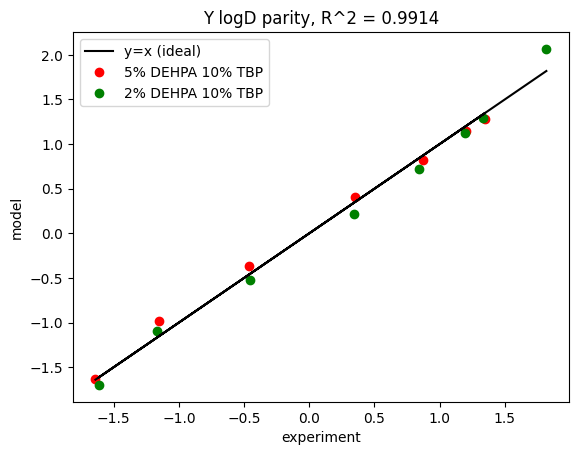

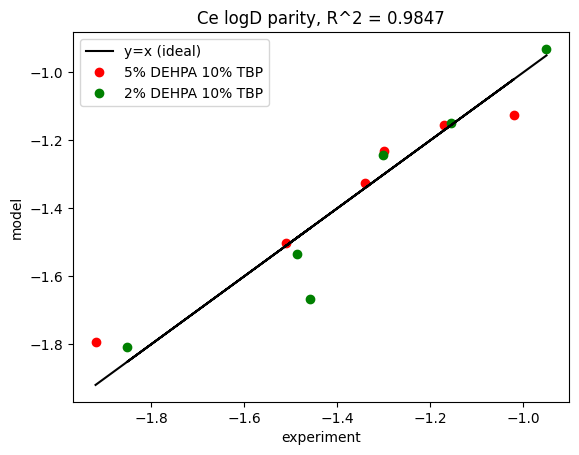

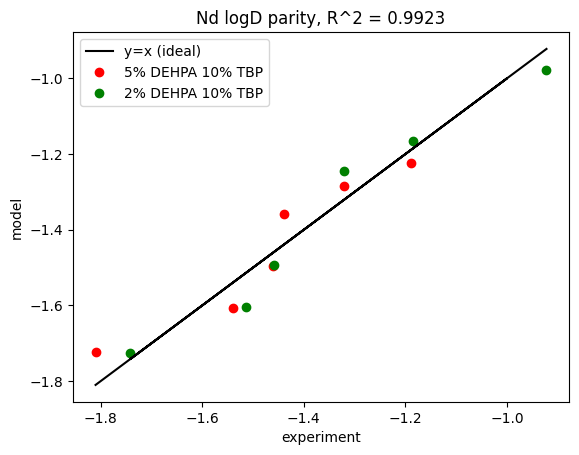

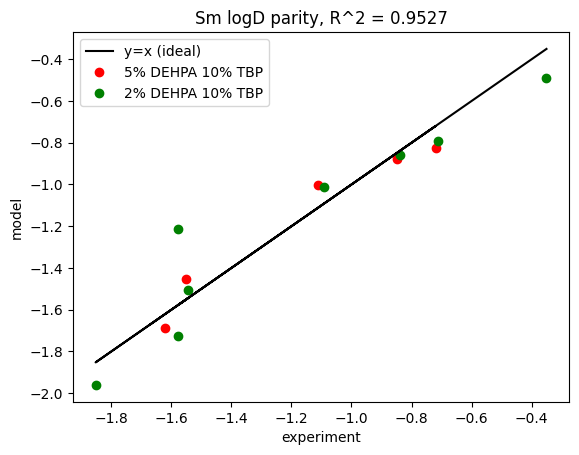

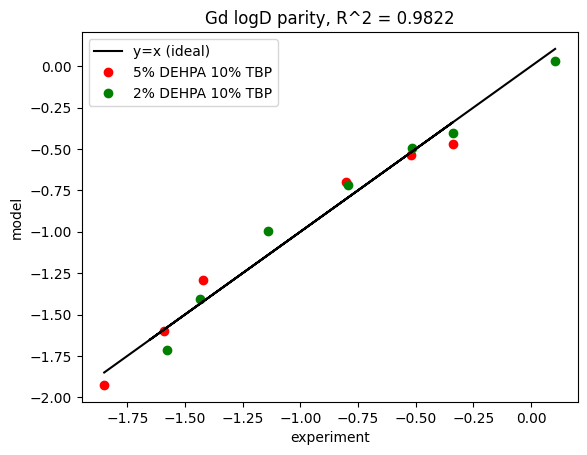

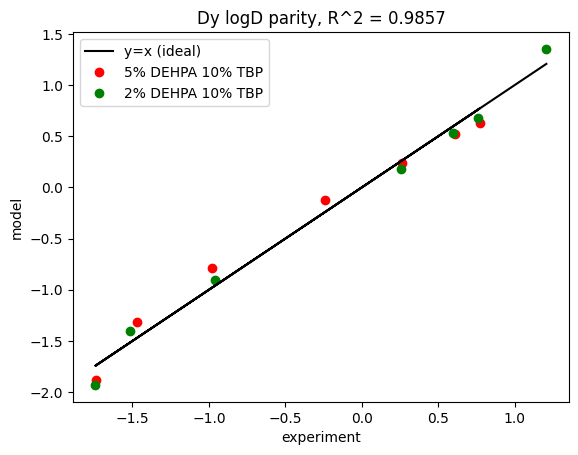

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

for e in Element_list:
    x = [m.logD_exp[i, e].value*df[f'w_{e}'][i] for i in idx_list]
    y = [m.logD_model[i, e].value*df[f'w_{e}'][i] for i in idx_list]
    x_ideal = [m.logD_exp[i, e].value for i in idx_list]
    plt.plot(x_ideal, x_ideal, label='y=x (ideal)', linestyle='-', color='black')
    red_points = []
    green_points = []
    for i in idx_list:
        if df[f'w_{e}'][i] == 1:
            if 2 <df['dosage'][i] <5:
                red_points.append(plt.scatter(x[i], y[i], color='red', label='5% DEHPA 10% TBP'))
            if df['dosage'][i] < 2:
                green_points.append(plt.scatter(x[i], y[i], color='green', label='2% DEHPA 10% TBP'))
    plt.xlabel('experiment')
    plt.ylabel('model')
    plt.title(f"{e} logD parity, R^2 = {r2_score(x, y):.4f}")
    
    # Build legend handles/labels manually to avoid duplicates
    handles = [plt.Line2D([], [], color='black', label='y=x (ideal)')]
    if red_points:
        handles.append(plt.Line2D([], [], color='red', marker='o', linestyle='None', label='5% DEHPA 10% TBP'))
    if green_points:
        handles.append(plt.Line2D([], [], color='green', marker='o', linestyle='None', label='2% DEHPA 10% TBP'))
    labels = [h.get_label() for h in handles]
    plt.legend(handles, labels)
    plt.show()

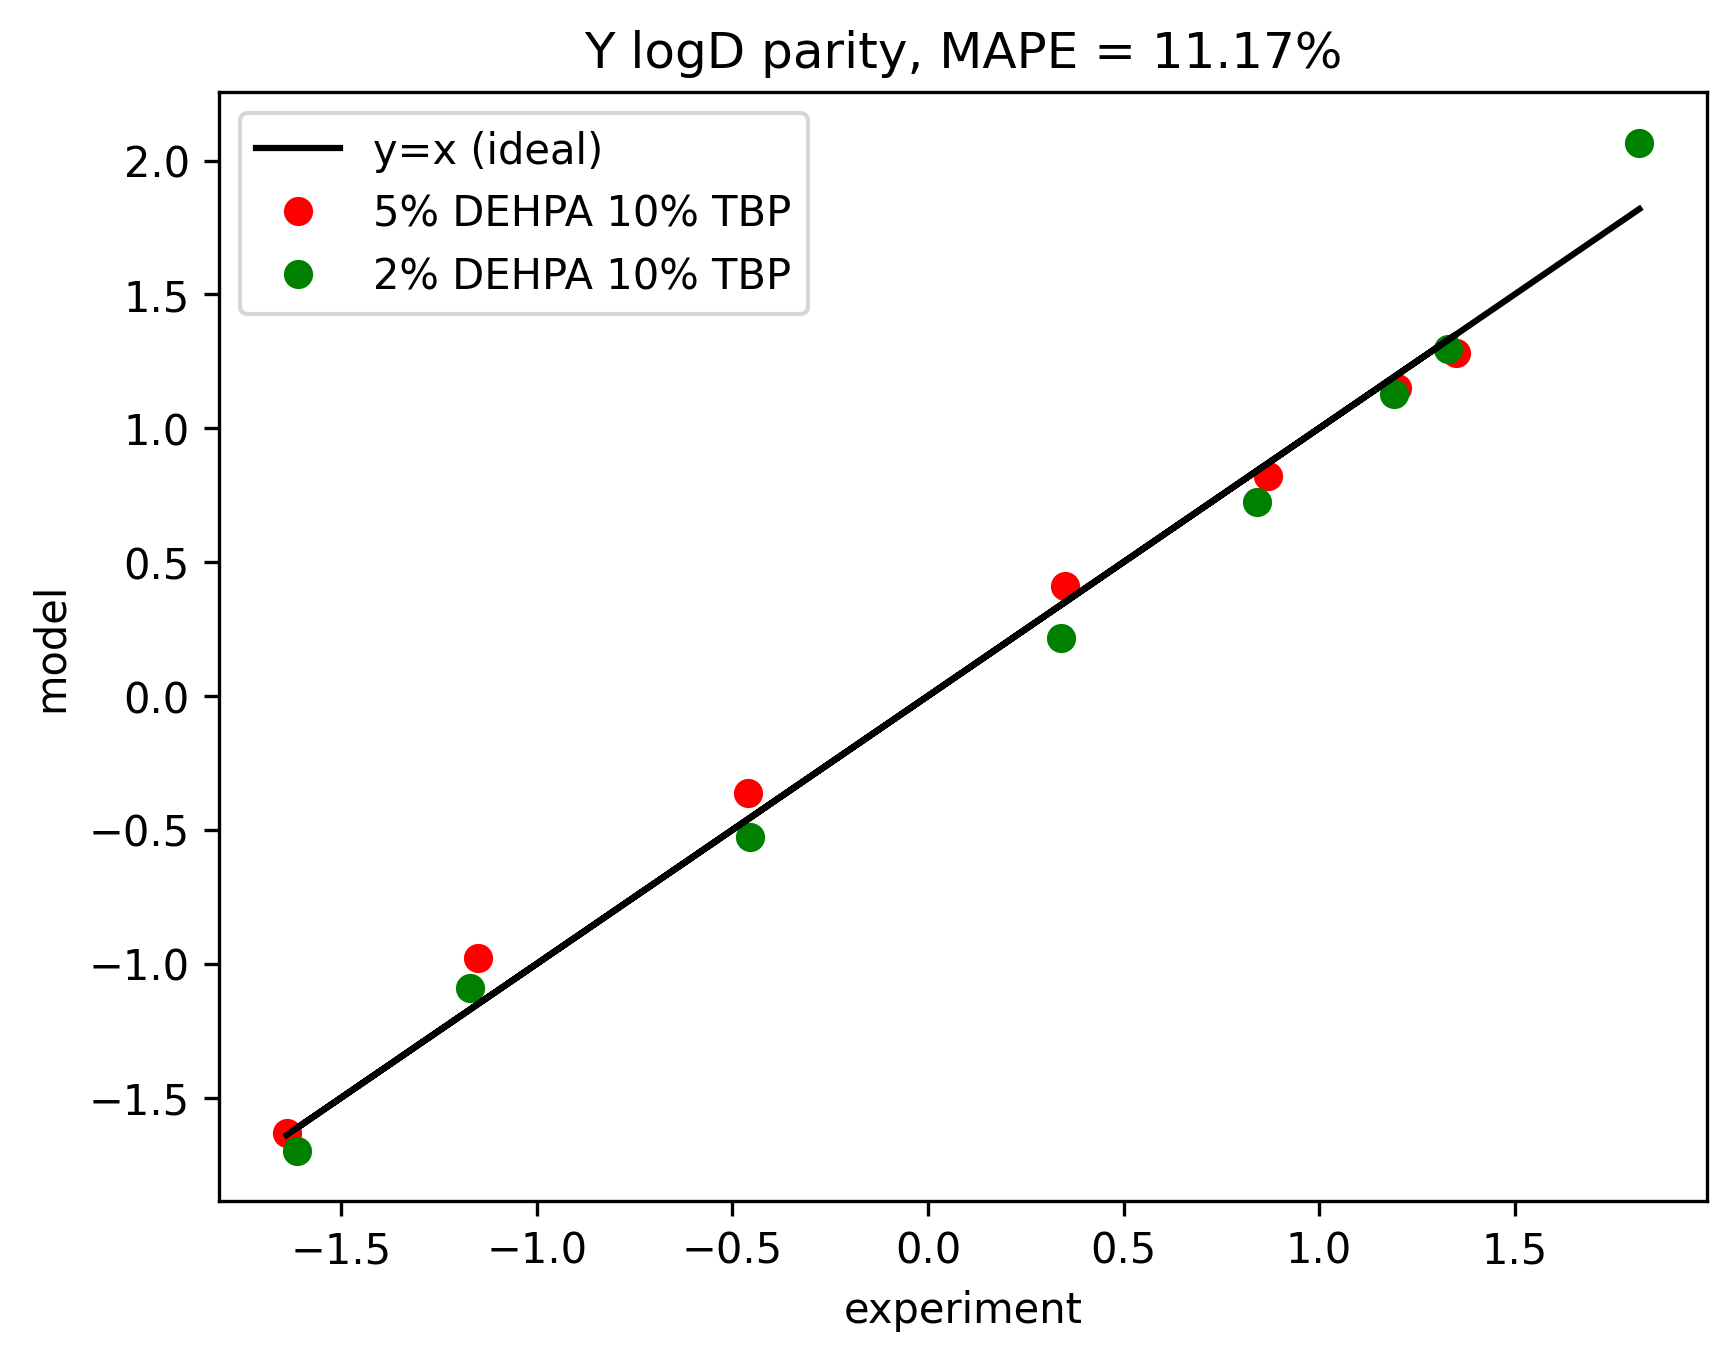

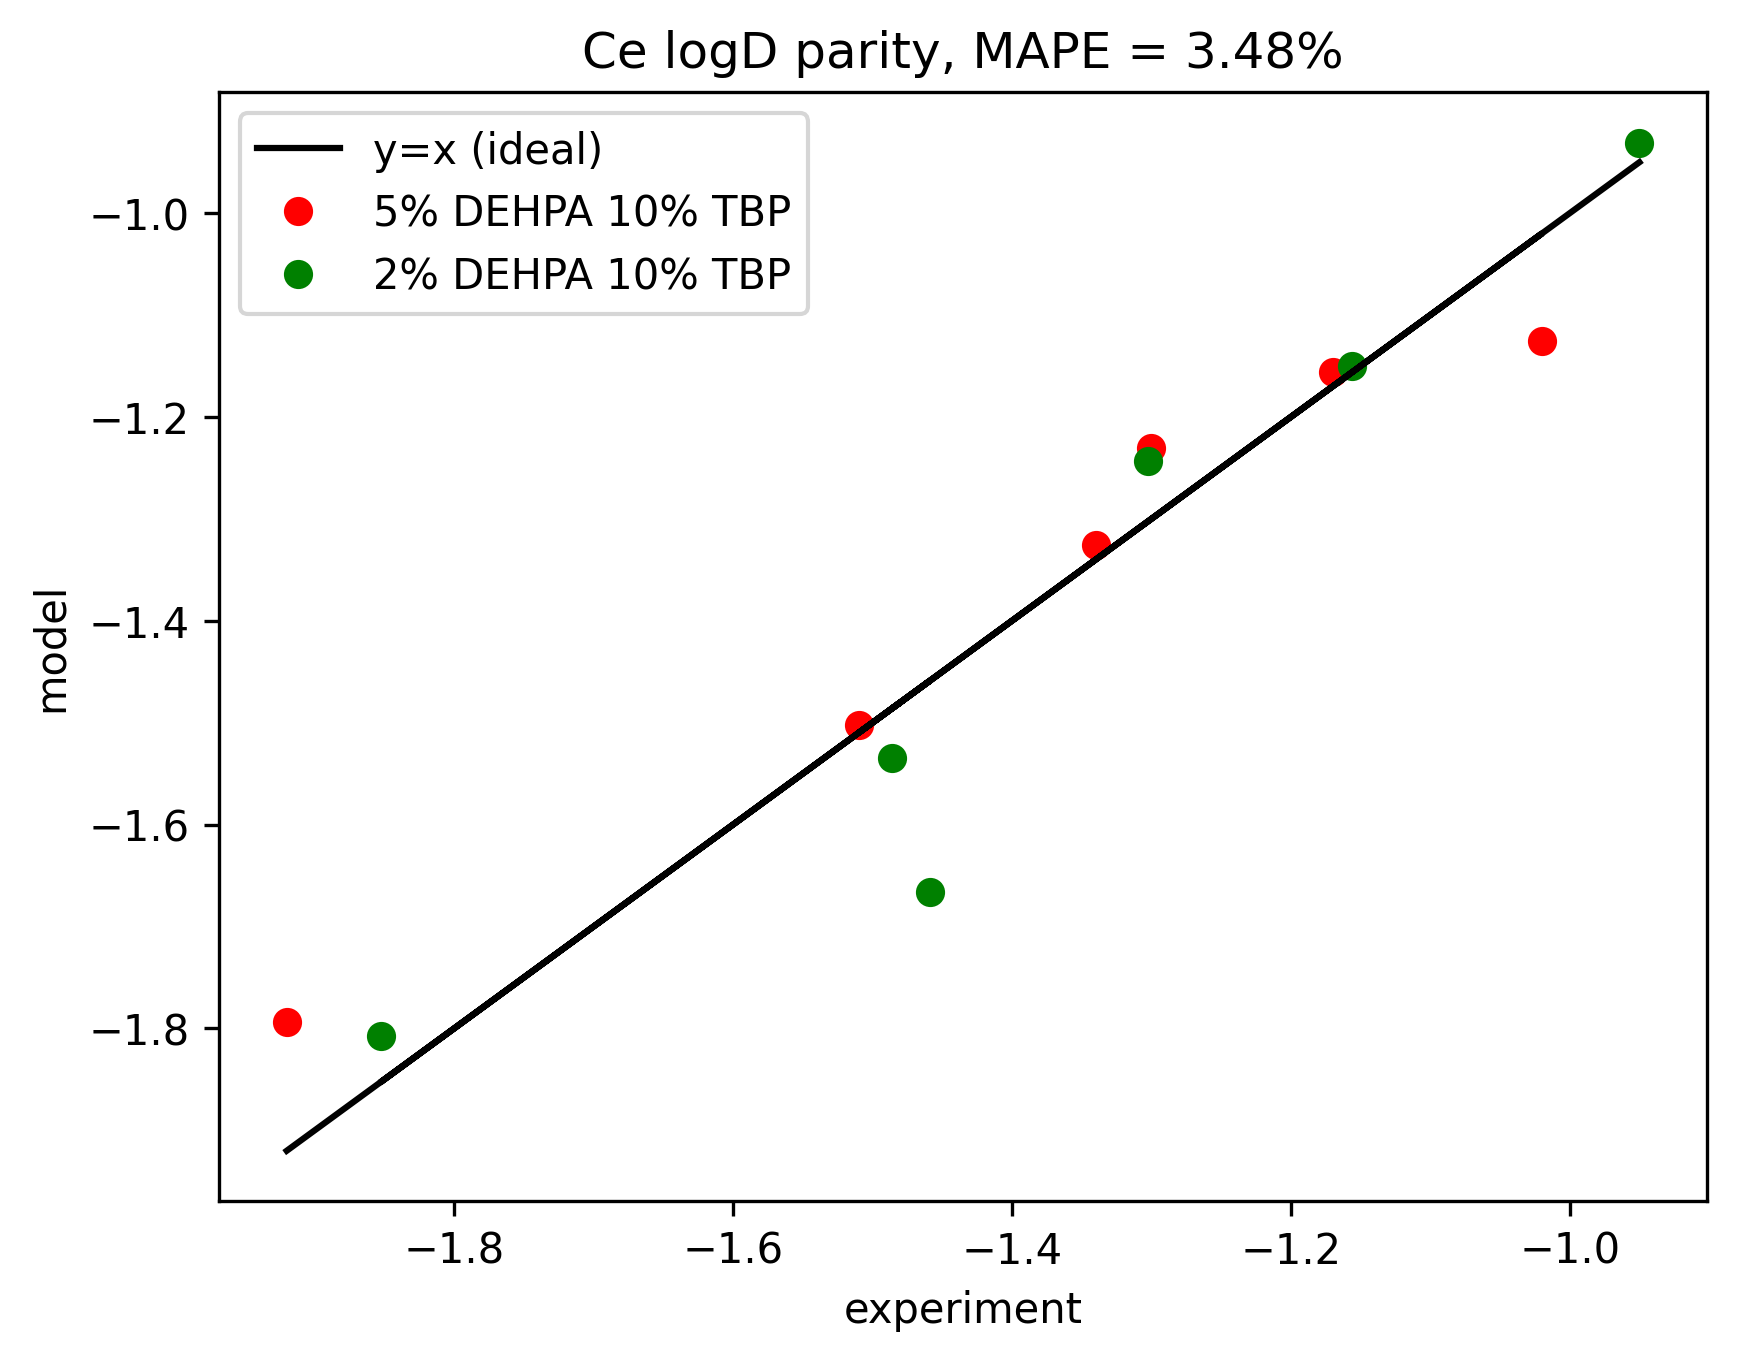

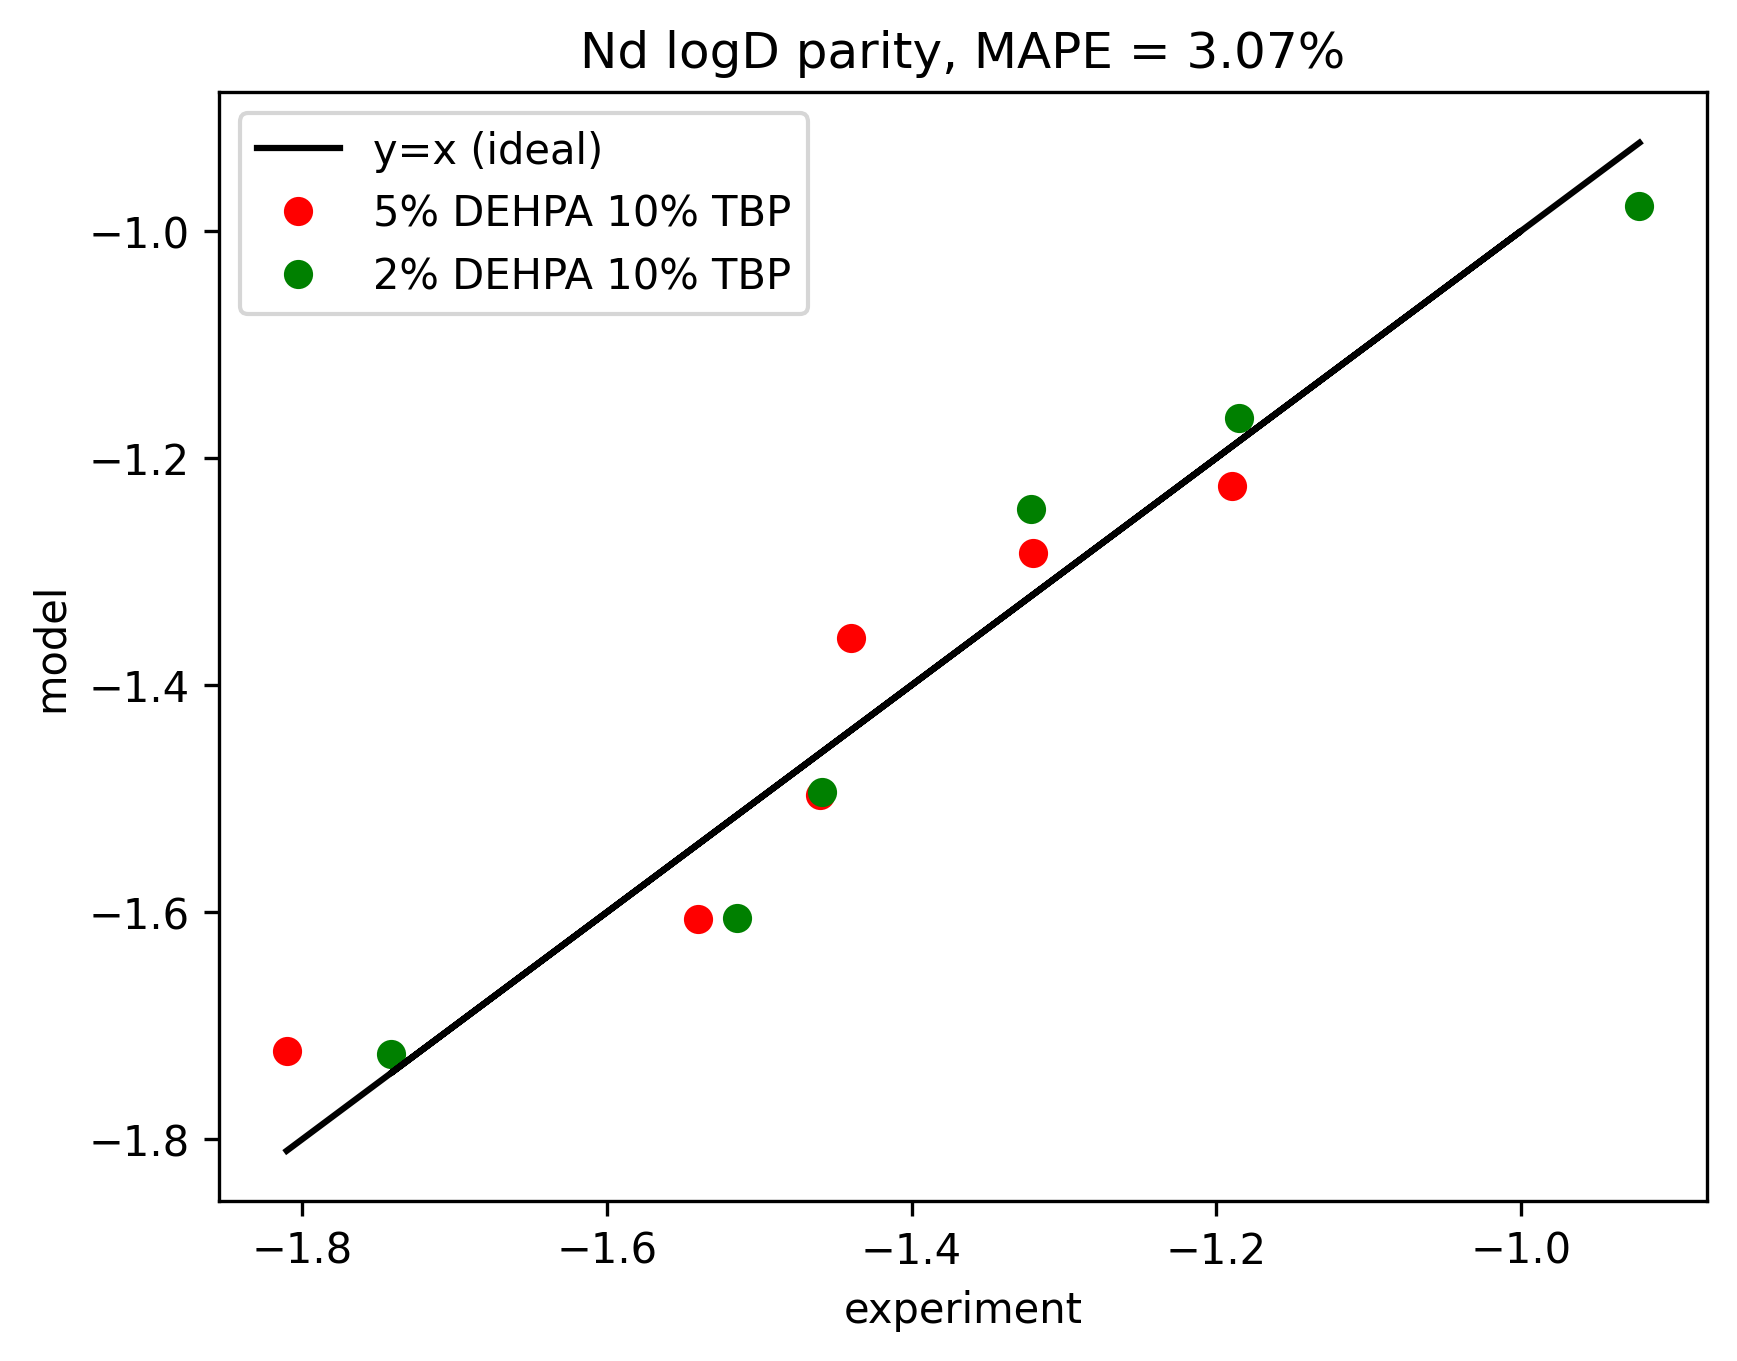

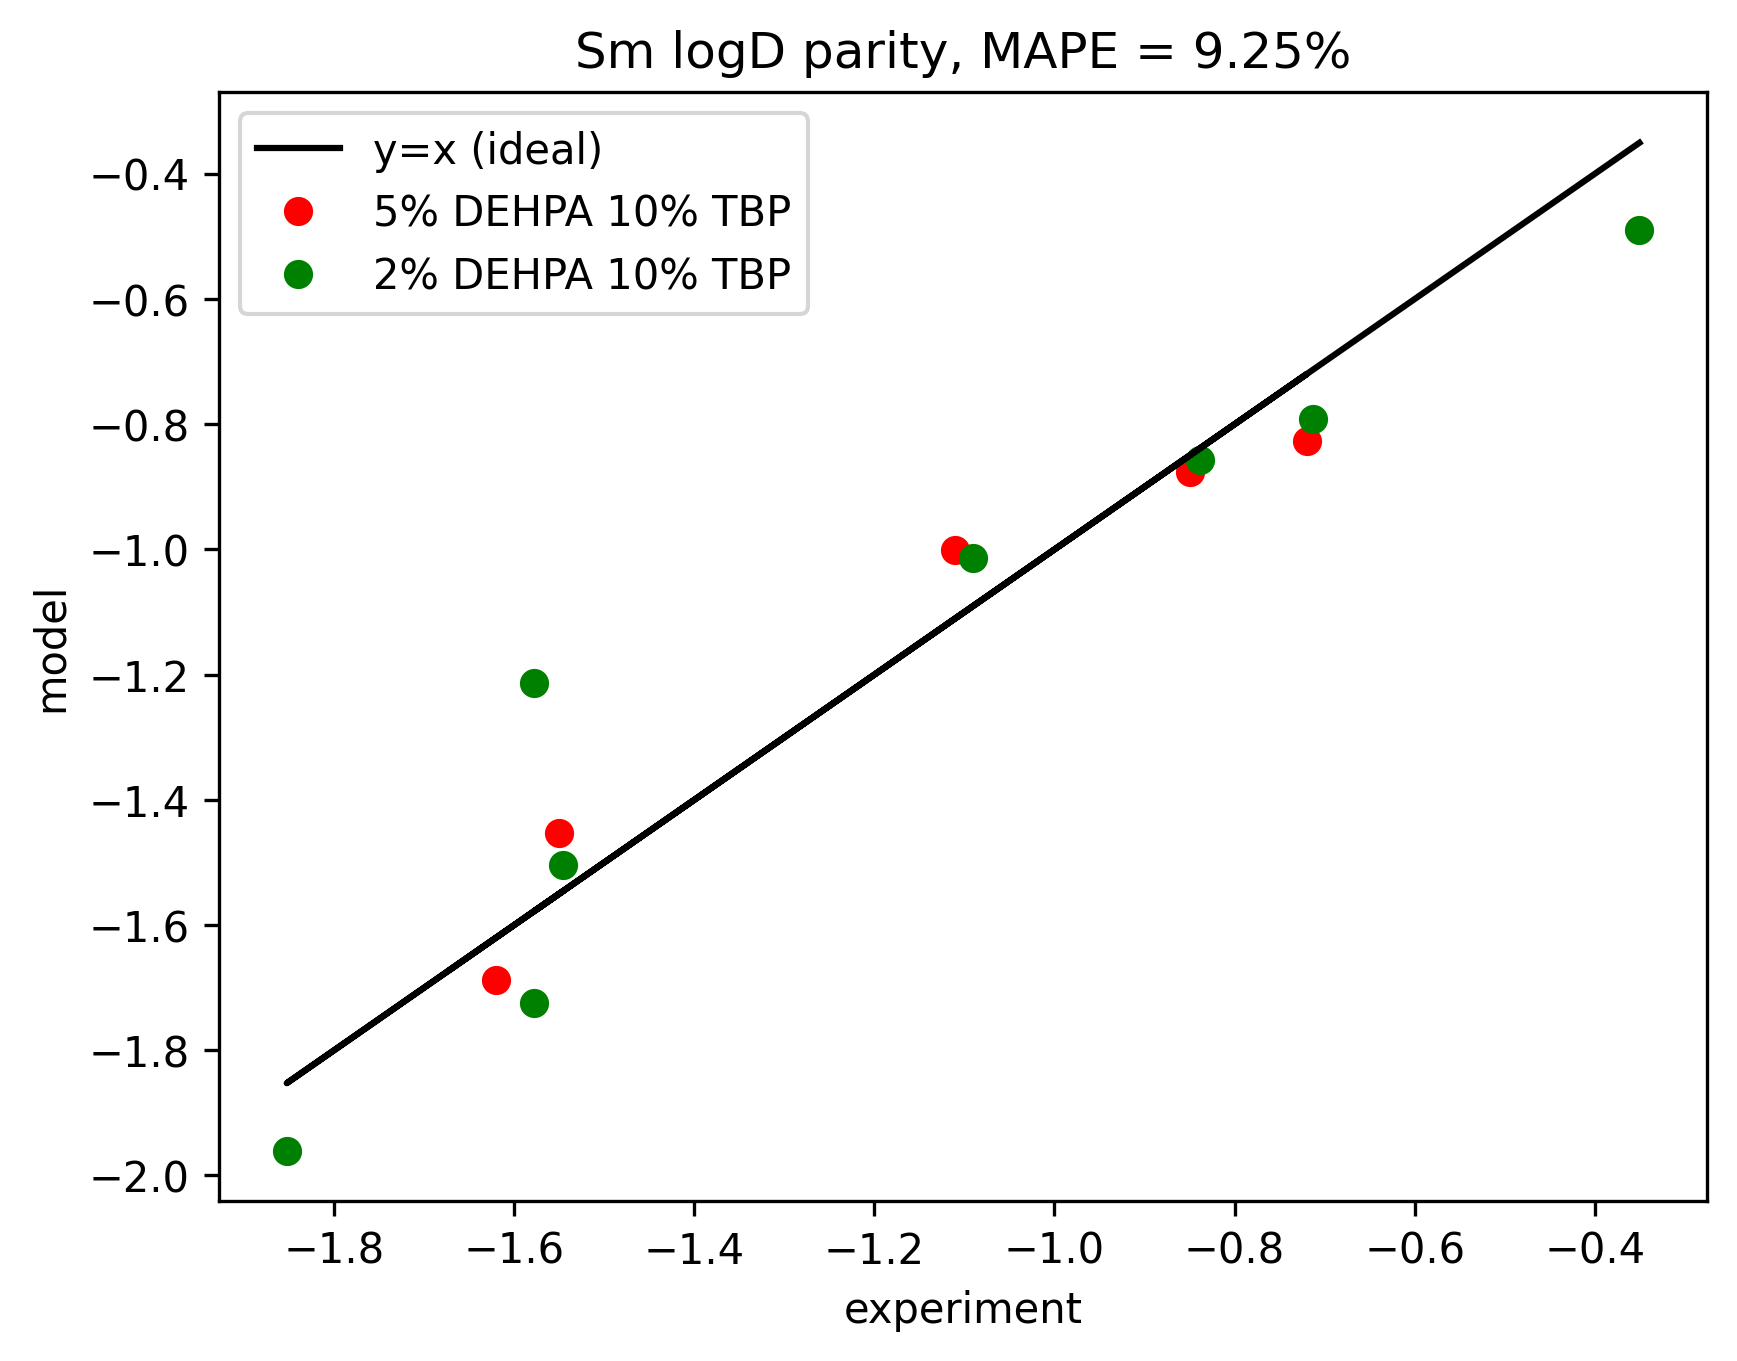

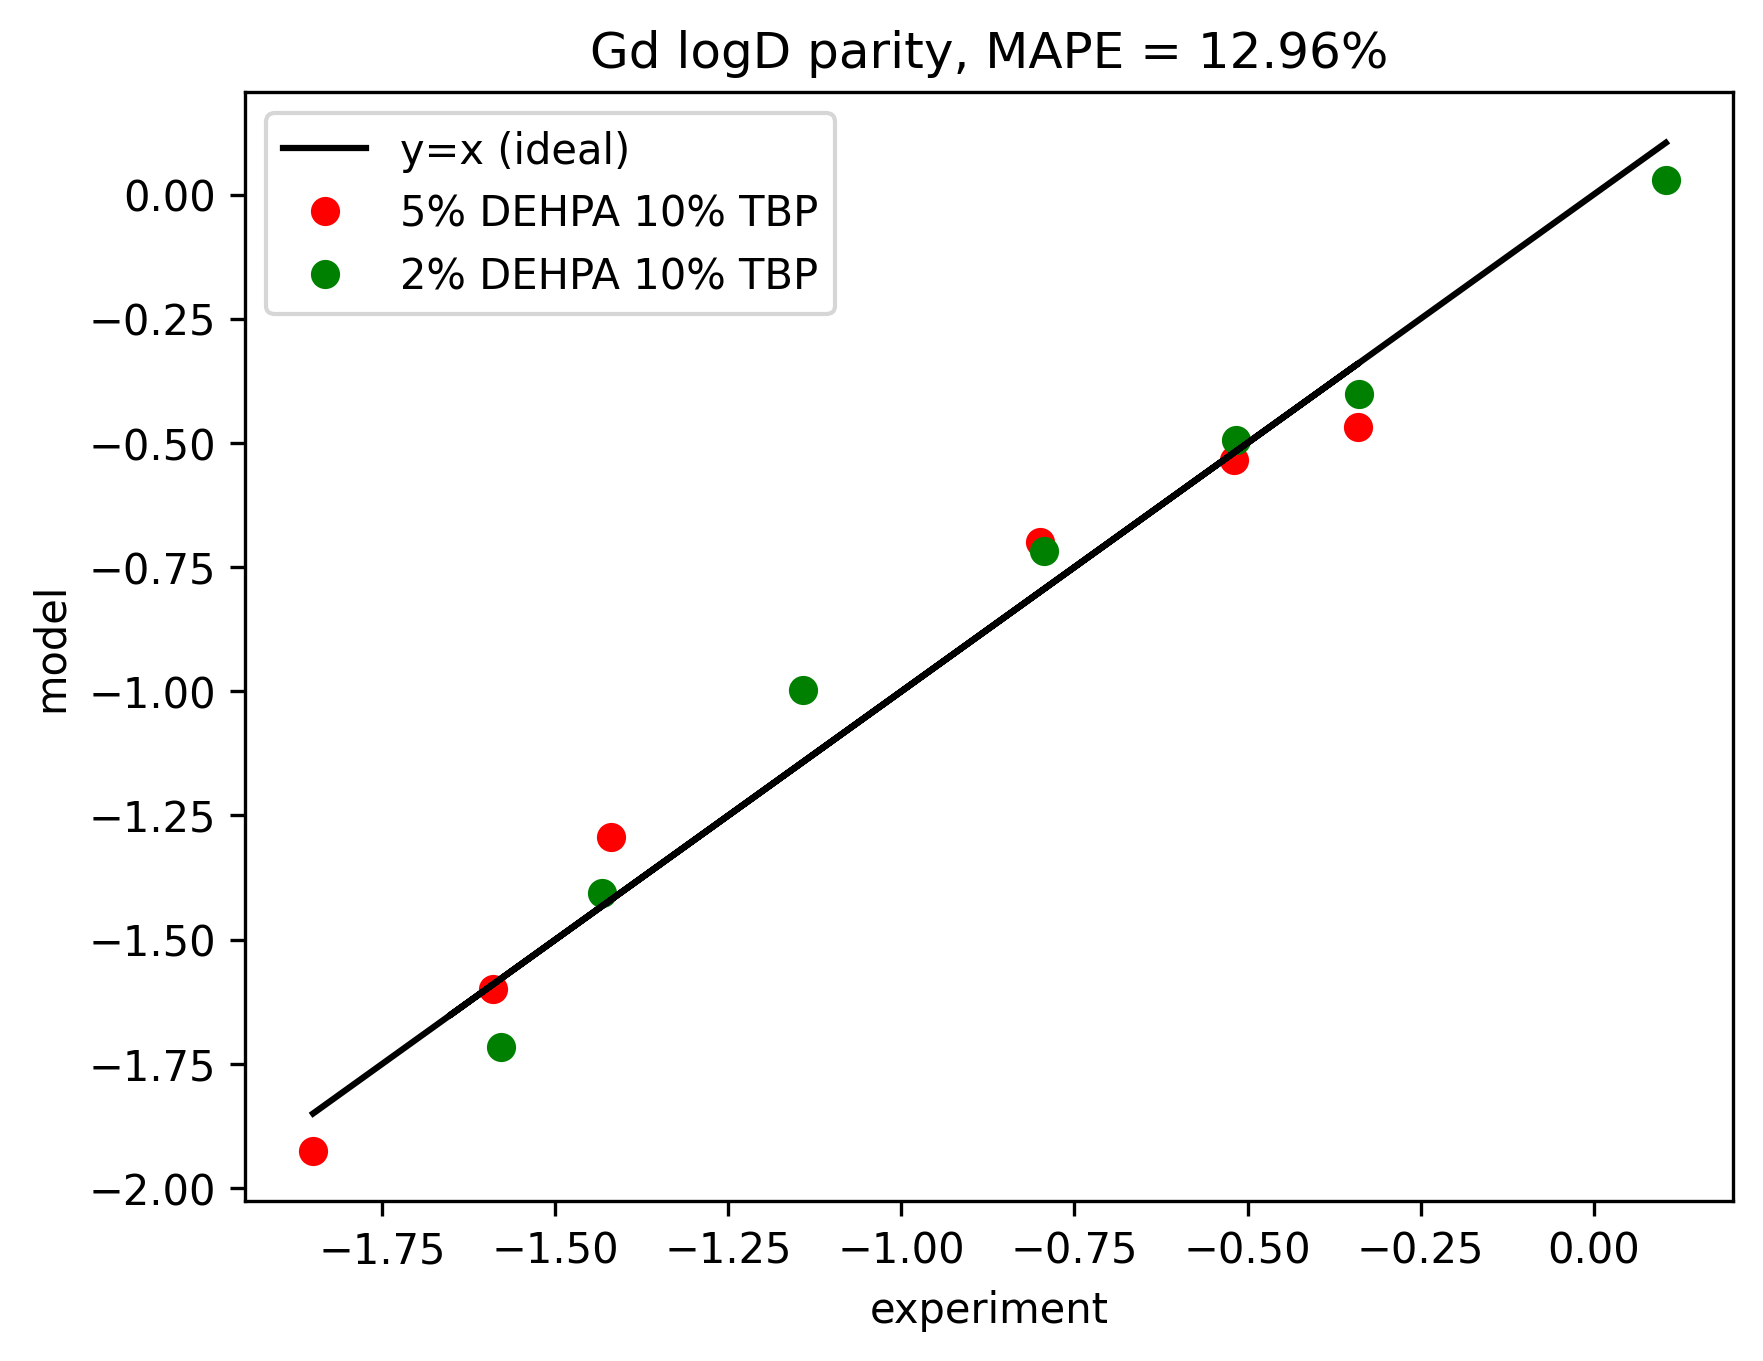

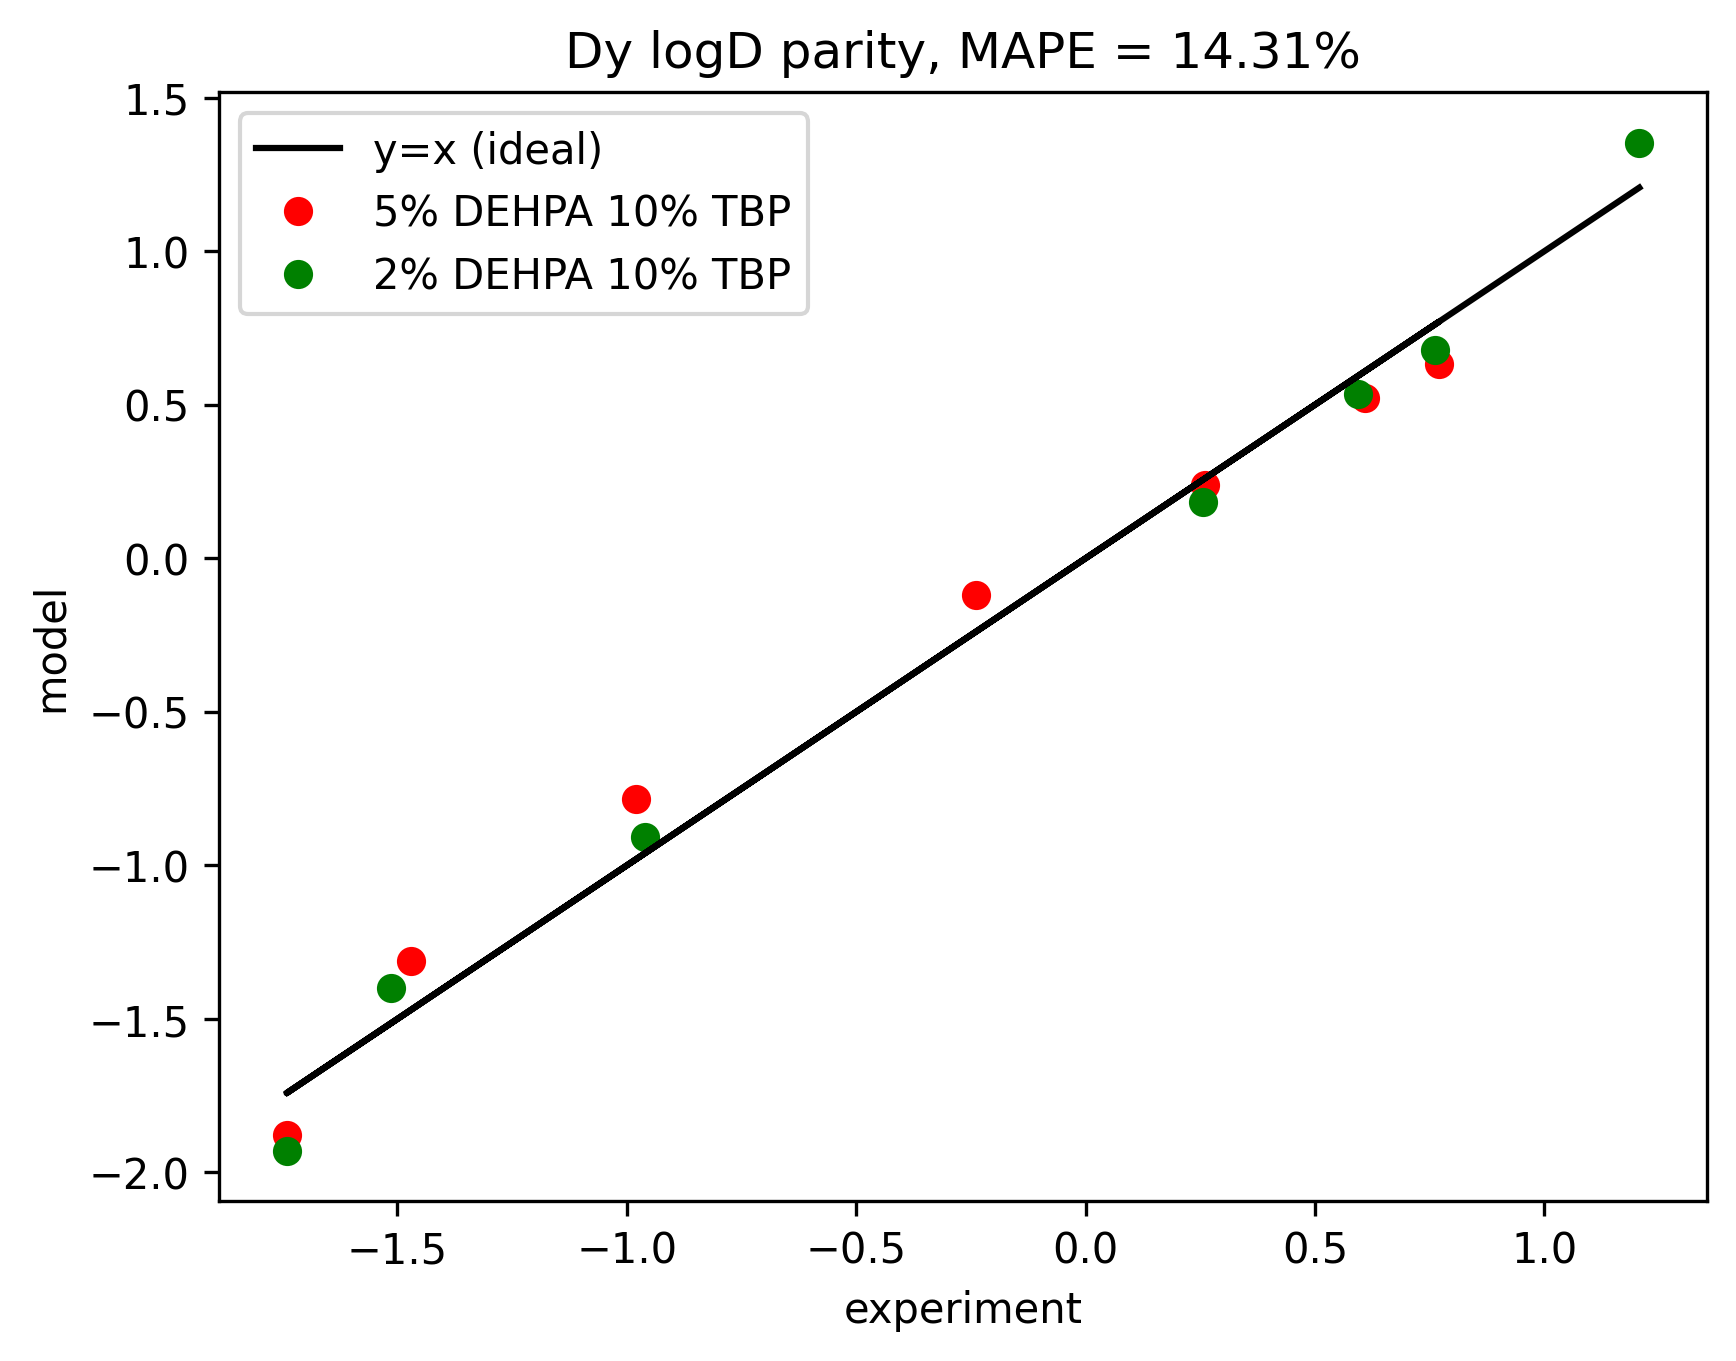

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error

for e in Element_list:
    plt.figure(dpi=300)
    x = [m.logD_exp[i, e].value*df[f'w_{e}'][i] for i in idx_list]
    y = [m.logD_model[i, e].value*df[f'w_{e}'][i] for i in idx_list]
    x_ideal = [m.logD_exp[i, e].value for i in idx_list]
    plt.plot(x_ideal, x_ideal, label='y=x (ideal)', linestyle='-', color='black')
    red_points = []
    green_points = []
    for i in idx_list:
        if df[f'w_{e}'][i] == 1:
            if 2 <df['dosage'][i] <5:
                red_points.append(plt.scatter(x[i], y[i], color='red', label='5% DEHPA 10% TBP'))
            if df['dosage'][i] < 2:
                green_points.append(plt.scatter(x[i], y[i], color='green', label='2% DEHPA 10% TBP'))
    plt.xlabel('experiment')
    plt.ylabel('model')
    plt.title(f"{e} logD parity, MAPE = {mean_absolute_percentage_error(x, y)*100:.2f}%")
    
    # Build legend handles/labels manually to avoid duplicates
    handles = [plt.Line2D([], [], color='black', label='y=x (ideal)')]
    if red_points:
        handles.append(plt.Line2D([], [], color='red', marker='o', linestyle='None', label='5% DEHPA 10% TBP'))
    if green_points:
        handles.append(plt.Line2D([], [], color='green', marker='o', linestyle='None', label='2% DEHPA 10% TBP'))
    labels = [h.get_label() for h in handles]
    plt.legend(handles, labels)
    plt.show()

In [8]:
df_parameters = pd.DataFrame(index=Element_list, columns=['a1','a2','b1','b2'])
for e in Element_list:
    df_parameters.loc[e, 'a1'] = m.a[1,e].value
    df_parameters.loc[e, 'a2'] = m.a[2,e].value
    df_parameters.loc[e, 'b1'] = m.b[1,e].value
    df_parameters.loc[e, 'b2'] = m.b[2,e].value

In [9]:
df_parameters

,a1,a2,b1,b2
Y,1.923028,0.074853,-2.186904,0.000001
Ce,0.451805,0.014818,-1.92042,0.000001
Nd,0.406063,0.0,-1.820107,0.000002
Sm,0.764036,0.021876,-2.153372,0.008403
Gd,1.141498,0.000002,-2.407248,0.296711
Dy,1.689088,0.05774,-2.354474,0.000001


In [30]:
with pd.ExcelWriter('data for parmest.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_parameters.to_excel(writer, sheet_name='parameter values out dosage')

In [10]:
for i in RangeSet(0,2):
    for j in RangeSet(0,1):
        print(j+1+2*i)

1
2
3
4
5
6


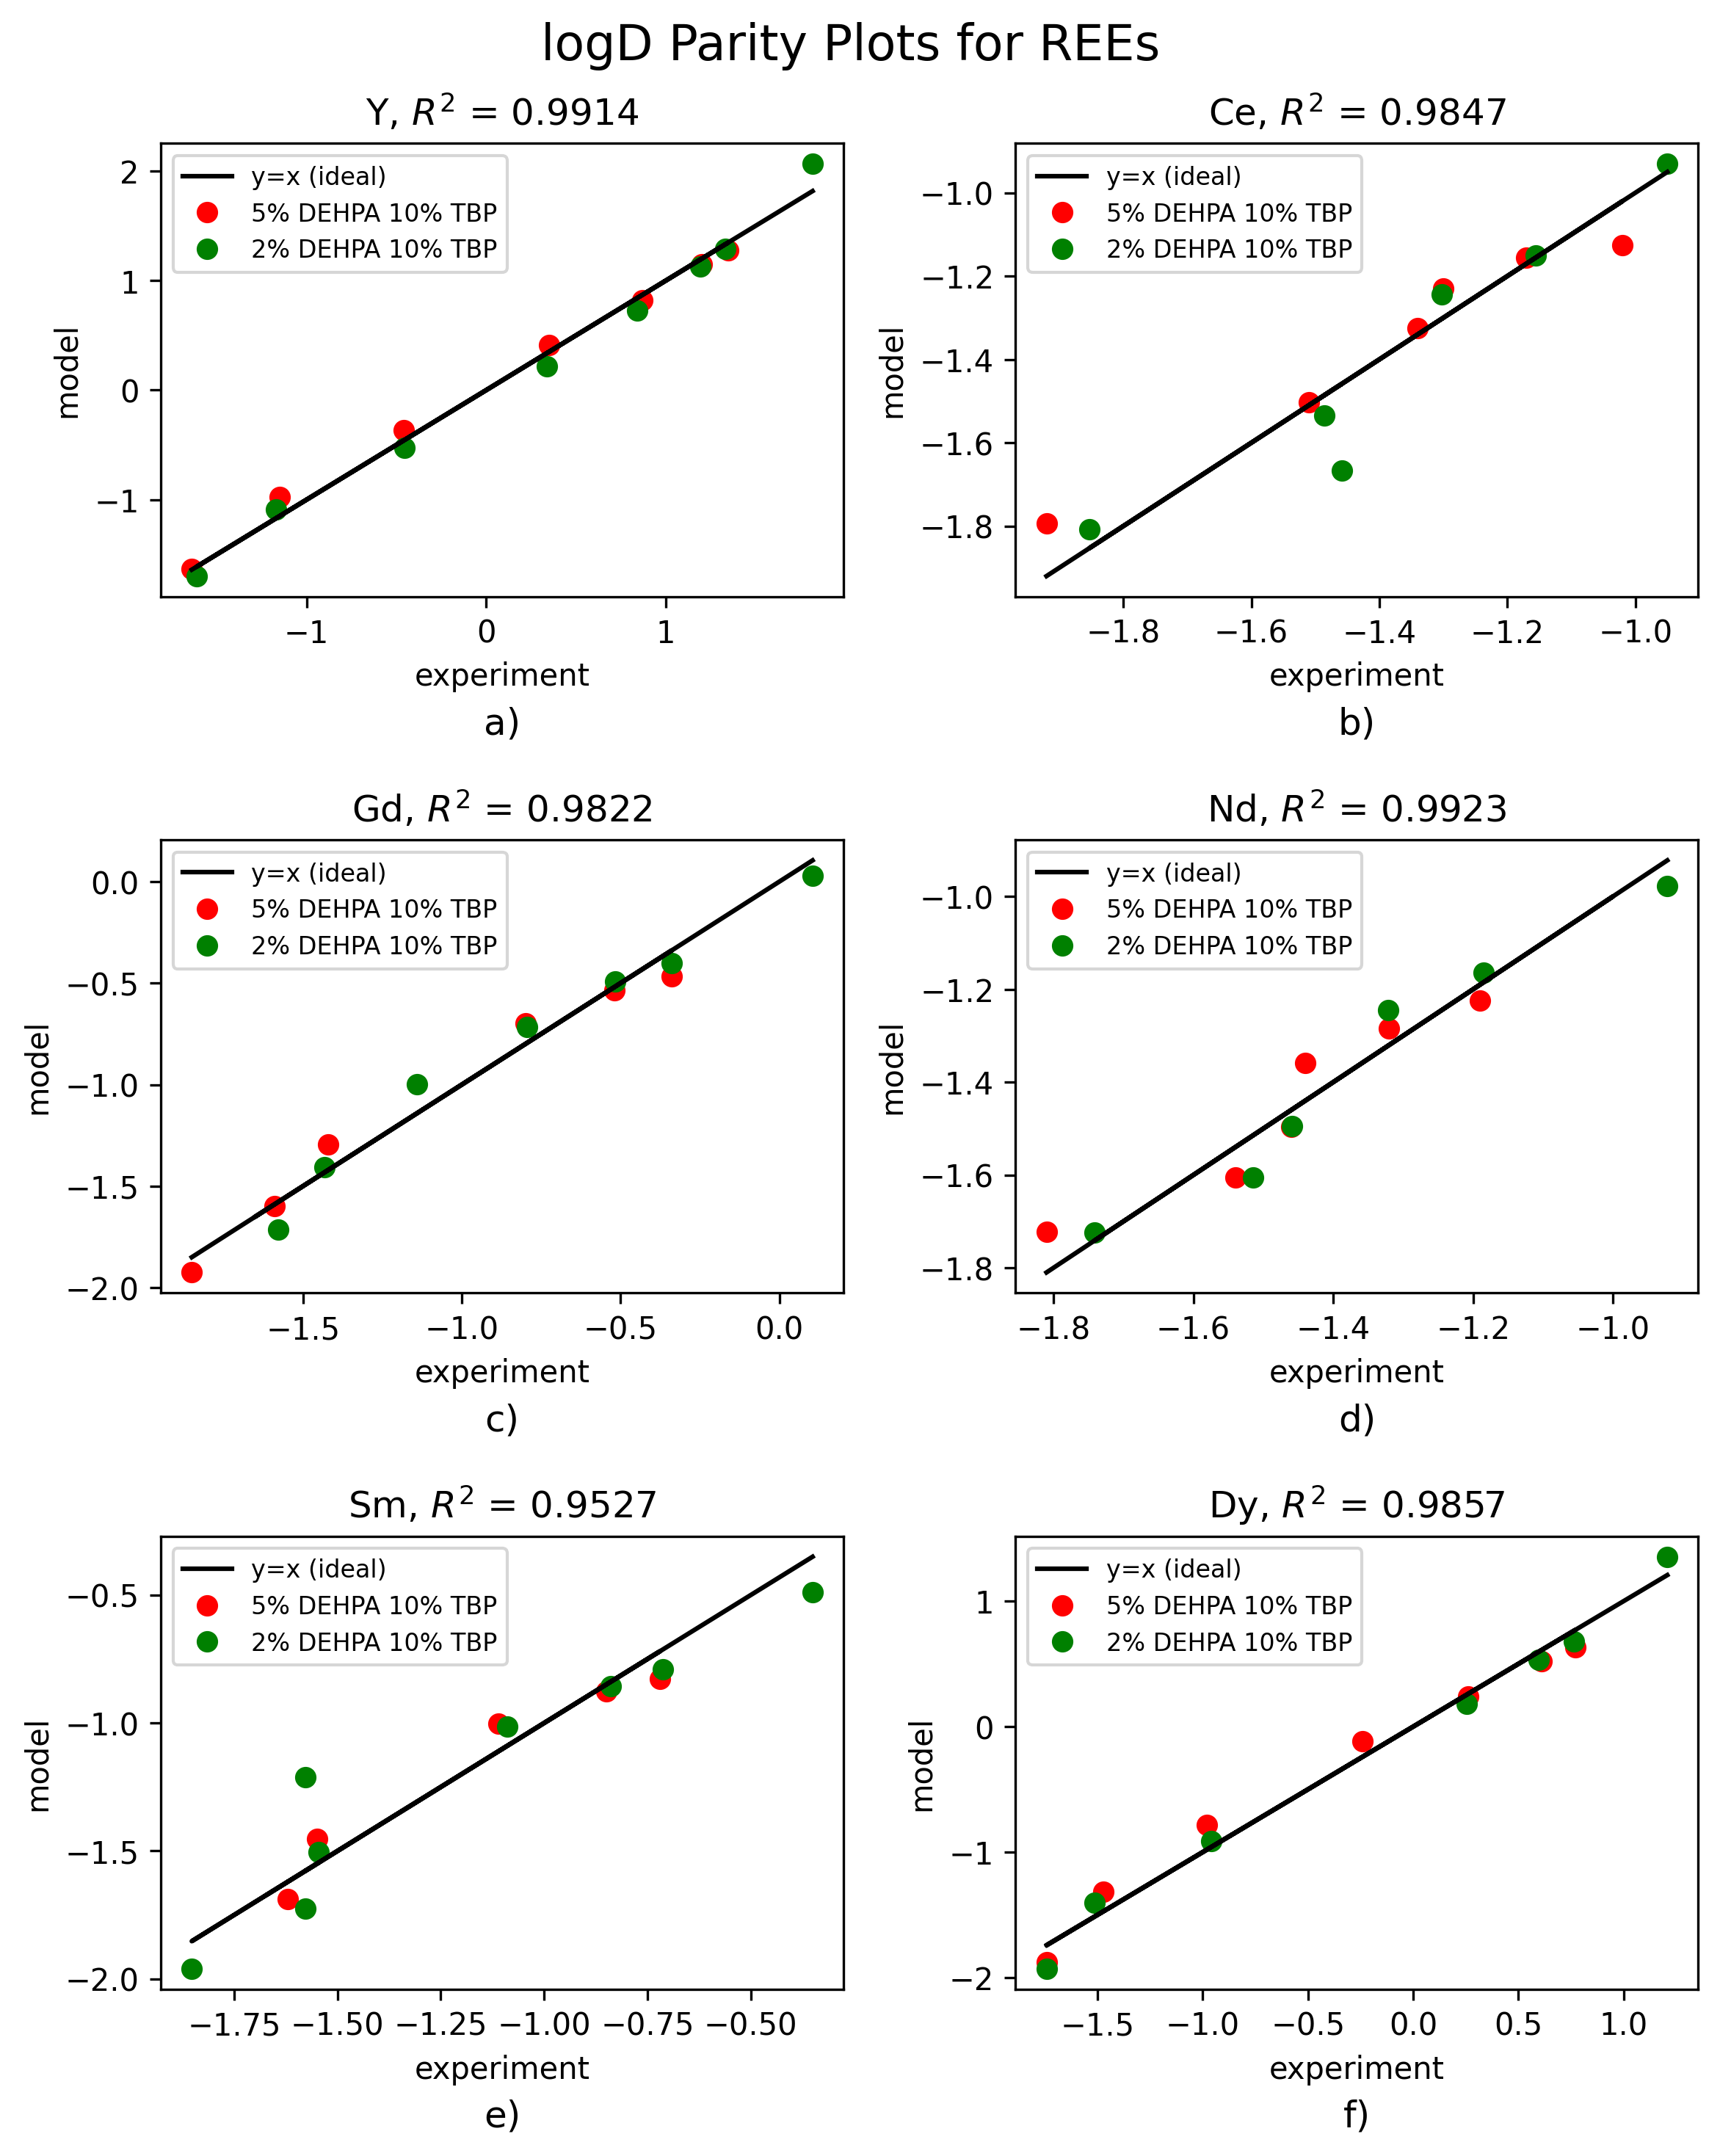

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

fig, ax = plt.subplots(3,2,figsize=(8,10),dpi=300)
fig.suptitle("logD Parity Plots for REEs", fontsize=16)
element_dict = dict(zip(RangeSet(1,6),['Y','Ce','Gd','Nd','Sm','Dy']))
text_label = dict(zip(RangeSet(1,6),['a)','b)','c)','d)','e)','f)']))
for a in RangeSet(0,2):
    for b in RangeSet(0,1):
        e = element_dict[b+1+2*a]
        txt_label=text_label[b+1+2*a]
        x = [m.logD_exp[i, e].value*df[f'w_{e}'][i] for i in idx_list]
        y = [m.logD_model[i, e].value*df[f'w_{e}'][i] for i in idx_list]
        x_ideal = [m.logD_exp[i, e].value for i in idx_list]
        ax[a,b].plot(x_ideal, x_ideal, label='y=x (ideal)', linestyle='-', color='black')
        red_points = []
        green_points = []
        for i in idx_list:
            if df[f'w_{e}'][i] == 1:
                if 2 <df['dosage'][i] <5:
                    red_points.append(ax[a,b].scatter(x[i], y[i], color='red', label='5% DEHPA 10% TBP'))
                if df['dosage'][i] < 2:
                    green_points.append(ax[a,b].scatter(x[i], y[i], color='green', label='2% DEHPA 10% TBP'))
        ax[a,b].set(xlabel='experiment',ylabel='model')
        ax[a,b].set_title(f"{e}, $R^2$ = {r2_score(x, y):.4f}")
        ax[a,b].text(0.5, -0.28, txt_label, transform=ax[a,b].transAxes,
                     ha='center', va='center', fontsize=12)
        # Build legend handles/labels manually to avoid duplicates
        handles = [plt.Line2D([], [], color='black', label='y=x (ideal)')]
        if red_points:
            handles.append(plt.Line2D([], [], color='red', marker='o', linestyle='None', label='5% DEHPA 10% TBP'))
        if green_points:
            handles.append(plt.Line2D([], [], color='green', marker='o', linestyle='None', label='2% DEHPA 10% TBP'))
        labels = [h.get_label() for h in handles]
        ax[a,b].legend(handles, labels, fontsize=8)
plt.tight_layout()
        